<a href="https://colab.research.google.com/github/Equivoke/DLS_part_1/blob/main/Alekseev_Nikita_semantic_segmentation_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>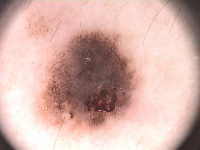</td><td>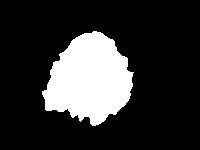</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
! wget https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar

#альтернативная ссылка на данные: https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2021-06-16 14:53:03--  https://www.dropbox.com/s/t0ichx42vg218hc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/t0ichx42vg218hc/PH2Dataset.rar [following]
--2021-06-16 14:53:04--  https://www.dropbox.com/s/raw/t0ichx42vg218hc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucefc9af33d60cbd1706d4e9b0eb.dl.dropboxusercontent.com/cd/0/inline/BQjwqNzvvW2SGtL8zbHDvwdES9_QqRFYm9Aj2aYGyRbe8r16e-o3kFjc-sn1IR9CmUQD4f1qGKk77vLNo8sZhnPX86OebTQCXjJ1h2AZ-bbuV4l3rrffRmVBb7VNJLkVahIznusAk5tzXzbNWez668QA/file# [following]
--2021-06-16 14:53:04--  https://ucefc9af33d60cbd1706d4e9b0eb.dl.dropboxusercontent.com/cd/0/inline/BQjwqNzvvW2SGtL8zbHDvwdES9_QqRFYm9Aj2aYGyRbe8r16e-o3kFjc-sn1IR9CmUQD4f1qGKk77vLNo8sZ

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256) #256*256
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

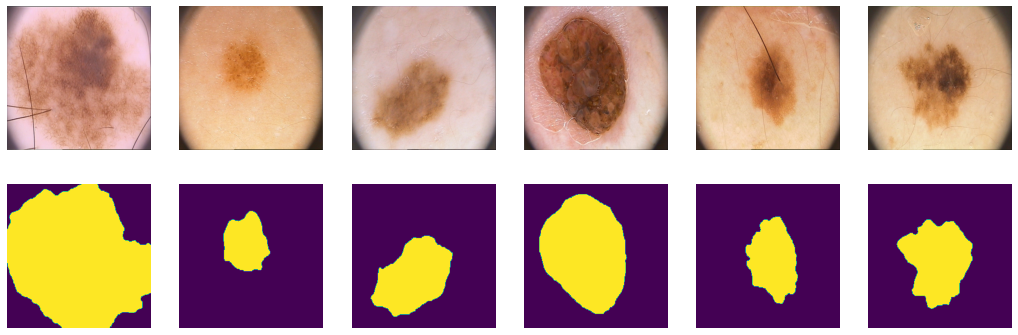

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

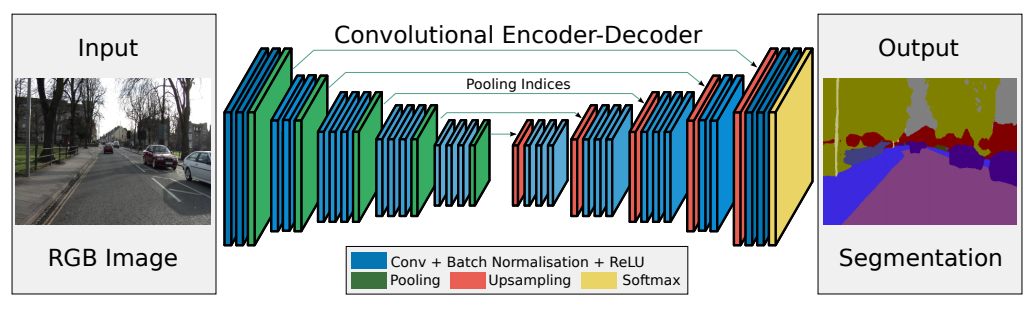

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size=3, padding=1),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),            
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3, padding=1),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32,kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),           
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride= 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride= 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32,kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32,kernel_size=3, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()           
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride= 2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16,kernel_size=3, padding=1),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16,kernel_size=3, padding=1),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride= 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1,kernel_size=3, padding=1),
            nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1,kernel_size=3, padding=1)
            )
    def forward(self, x):
        # encoder
        e0,indices_0 = F.max_pool2d_with_indices(self.enc_conv0(x), kernel_size=2, stride=2)
        e1,indices_1 = F.max_pool2d_with_indices(self.enc_conv1(e0), kernel_size=2, stride=2)
        e2,indices_2 = F.max_pool2d_with_indices(self.enc_conv2(e1), kernel_size=2, stride=2)
        e3,indices_3 = F.max_pool2d_with_indices(self.enc_conv3(e2), kernel_size=2, stride=2)
        # bottleneck
        b = self.bottleneck_conv(e3)
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices_3))
        d1 = self.dec_conv1(self.upsample1(d0, indices_2))
        d2 = self.dec_conv2(self.upsample2(d1, indices_1))
        d3 = self.dec_conv3(self.upsample3(d2, indices_0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = torch.logical_and(outputs,labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = torch.logical_or(outputs, labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    # return thresholded
    return torch.mean(iou)

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    t_bce_loss = torch.max(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    return t_bce_loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):
    X_val, Y_val = next(iter(data_val))
    hist_score = []
    hist_loss = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_val_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch.detach(), Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            # avg_loss_for_graph = avg_loss.detach().cpu()
            # losses.append(float(avg_loss_for_graph))
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        for X_batch_val, Y_batch_val in data_val:
          with torch.set_grad_enabled(False):
            # data to device
            X_batch_val = X_batch_val.to(device)
            Y_batch_val = Y_batch_val.to(device)
            # forward
            Y_pred_val = model(X_batch_val)
            loss = loss_fn(Y_batch_val.detach(), Y_pred_val) # forward-pass
            # calculate loss to show the user
            avg_val_loss += loss / len(data_val)
        with torch.no_grad():
          X_val = X_val.to(device)
          Y_hat = model(X_val)
          Y_hat = Y_hat.detach().cpu()
          X_val = X_val.cpu()
        # data logging
        model.eval()  # testing mode
        tr_scores = 0
        with torch.no_grad():
          for X_batch, Y_label in data_tr:
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            tr_scores += iou_pytorch(Y_pred > 0.5, Y_label.to(device)).mean().item()
          train_score = tr_scores/len(data_tr)
        # train_score = score_model(model=model, iou_pytorch, data_tr)
        print('train_score: %f' % train_score)
        # val_score = score_model(model=model, iou_pytorch, data_val)
        val_scores = 0
        with torch.no_grad():
          for X_batch, Y_label in data_val:
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            val_scores += iou_pytorch(Y_pred > 0.5, Y_label.to(device)).mean().item()
          val_score = val_scores/len(data_val)
        hist_score.append((train_score, val_score))
        hist_loss.append((avg_loss, avg_val_loss))
        # scheduler step
        scheduler.step()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return hist_score, hist_loss

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
torch.manual_seed(42)

In [ ]:
model = SegNet().to(device)

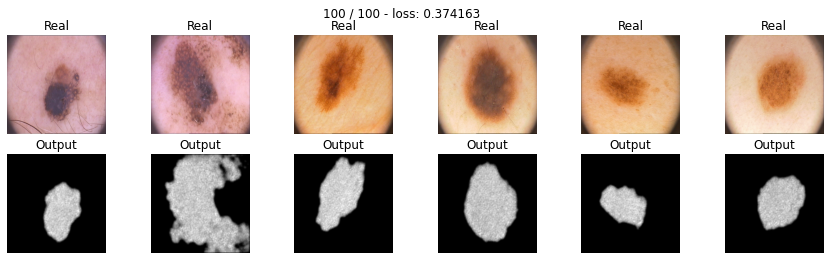

In [ ]:
max_epochs = 100
opt = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(opt, step_size = 20, gamma = 0.6)
bce_score_h, bce_loss_h  = train(model, opt, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.8556342422962189

In [ ]:
from matplotlib import pyplot as plt

Отрисуем графики скора для обучающей, валидационной и тестовой выборок.

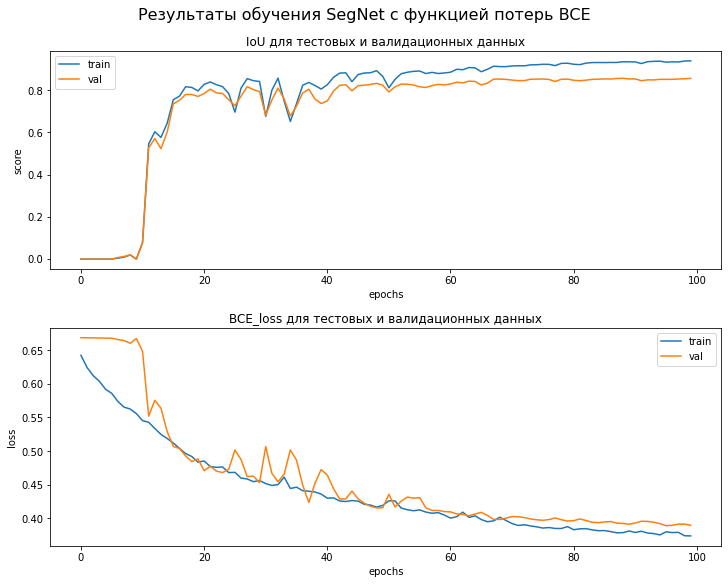

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["train", "val"]
fig.set_size_inches
axs[0].plot(bce_score_h)
axs[0].set_title('IoU для тестовых и валидационных данных')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Результаты обучения SegNet с функцией потерь BCE', fontsize=16)
axs[0].legend(labels)

axs[1].plot(bce_loss_h)
axs[1].set_title('BCE_loss для тестовых и валидационных данных')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].legend(labels)

plt.show()

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred, smooth=1e-3):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    intersection = (y_pred * y_real).sum()
    dice = (2 * intersection + smooth)/(y_pred.sum() + y_real.sum() + smooth)
    return 1 - dice

Проводим тестирование:

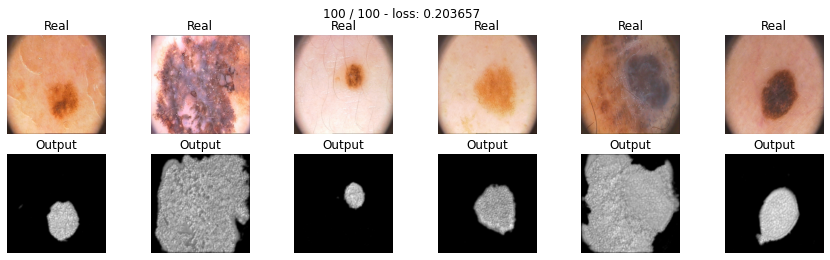

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 100
opt_dice = optim.Adam(model_dice.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(opt_dice, step_size = 20, gamma = 0.6)
dice_score_h, dice_loss_h = train(model_dice, opt_dice, dice_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.8226062059402466

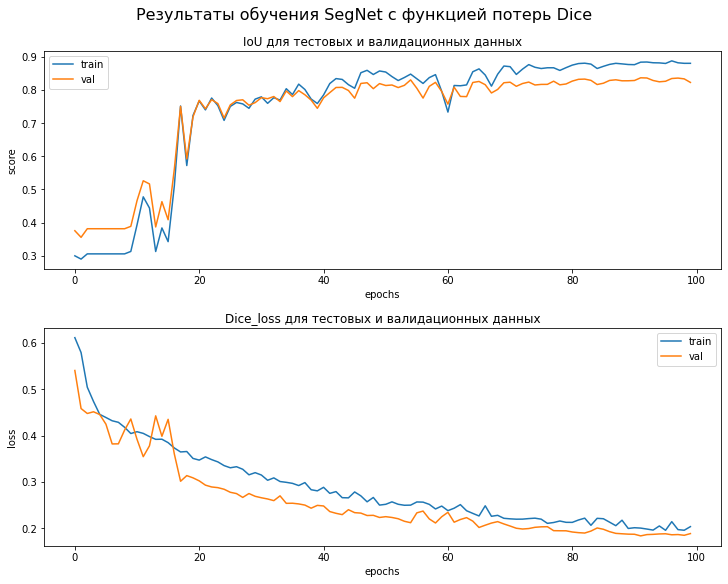

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["train", "val"]
fig.set_size_inches
axs[0].plot(dice_score_h)
axs[0].set_title('IoU для тестовых и валидационных данных')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Результаты обучения SegNet с функцией потерь Dice', fontsize=16)
axs[0].legend(labels)

axs[1].plot(dice_loss_h)
axs[1].set_title('Dice_loss для тестовых и валидационных данных')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].legend(labels)

plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
        bce_loss_fl = torch.max(y_pred, torch.zeros_like(y_pred)) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
        pt = torch.exp(-bce_loss_fl)
        F_loss = (1-pt)**gamma * bce_loss_fl
        return F_loss.mean()

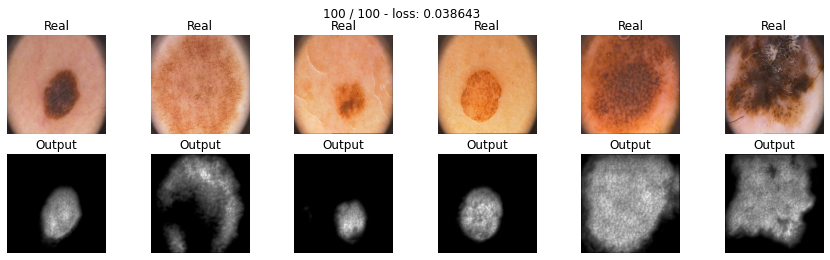

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 100
opt_focal = optim.Adam(model_focal.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(opt_focal, step_size = 20, gamma = 0.6)
focal_score_h, focal_loss_h = train(model_focal, opt_focal, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.8272747695446014

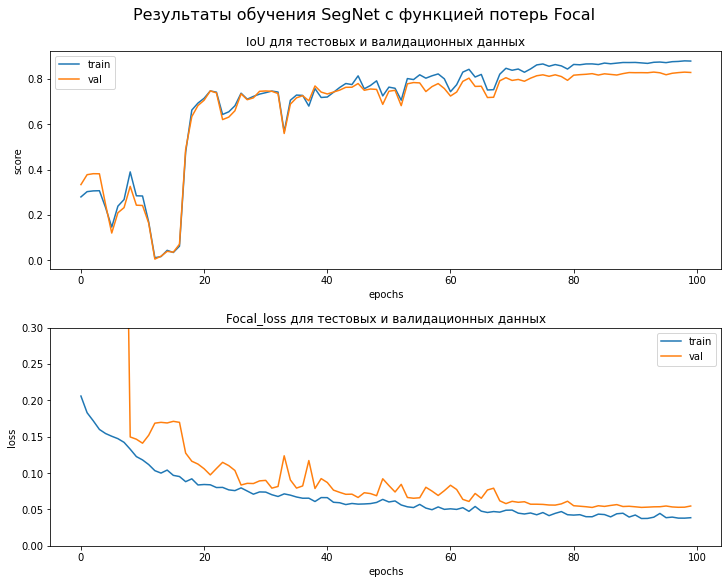

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["train", "val"]
fig.set_size_inches
axs[0].plot(focal_score_h)
axs[0].set_title('IoU для тестовых и валидационных данных')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Результаты обучения SegNet с функцией потерь Focal', fontsize=16)
axs[0].legend(labels)

axs[1].plot(focal_loss_h)
axs[1].set_title('Focal_loss для тестовых и валидационных данных')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].axis(ymin=0,ymax=0.3)
axs[1].legend(labels)

plt.show()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

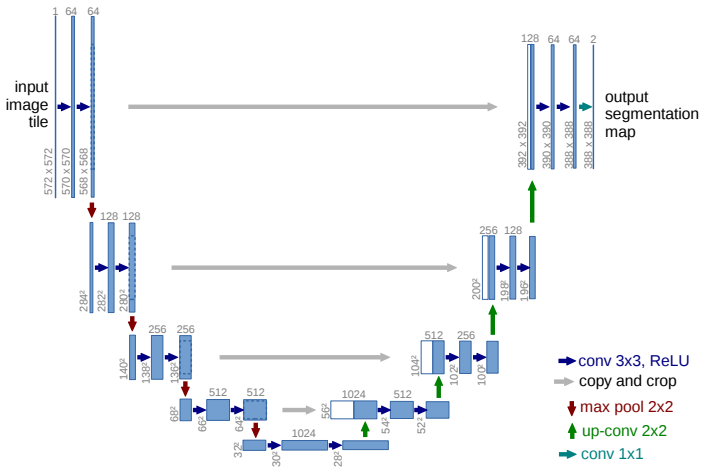

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride = 2 )   # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, padding=1),           
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2 ) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3, padding=1),           
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride = 2 ) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride = 2 ) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3, padding=1),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024,kernel_size=3, padding=1),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size = 2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=3, padding=1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size = 2, stride=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,kernel_size=3, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3, padding=1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size = 2, stride=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3, padding=1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64,kernel_size = 2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),           
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1,kernel_size=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_p = self.pool0(e0)
        e1 = self.enc_conv1(e0_p)
        e1_p = self.pool1(e1)
        e2 = self.enc_conv2(e1_p)
        e2_p = self.pool2(e2)
        e3 = self.enc_conv3(e2_p)
        e3_p = self.pool3(e3)
        # # bottleneck
        b = self.bottleneck_conv(e3_p)

        # decoder
        d0_1 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat([d0_1, e3], 1))
        d1_1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat([d1_1, e2], 1))
        d2_1 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat([d2_1, e1], 1))
        d3_1 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([d3_1, e0], 1))  # no activation
        return d3

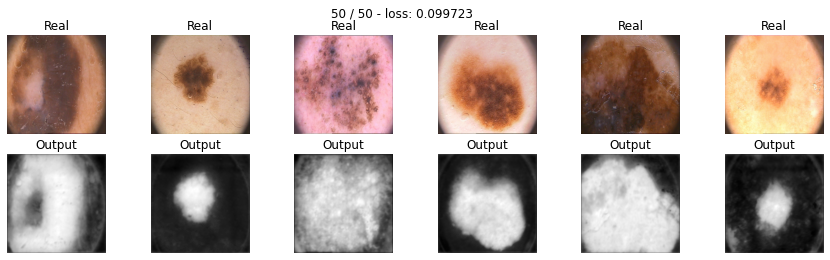

In [ ]:
unet_model_bce = UNet().to(device)
max_epochs = 50
opt_unet = optim.Adam(unet_model_bce.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(opt_unet, step_size = 20, gamma = 0.6)
unet_score_h, unet_loss_h = train(unet_model_bce, opt_unet, bce_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(unet_model_bce, iou_pytorch, data_val)

0.8603398203849792

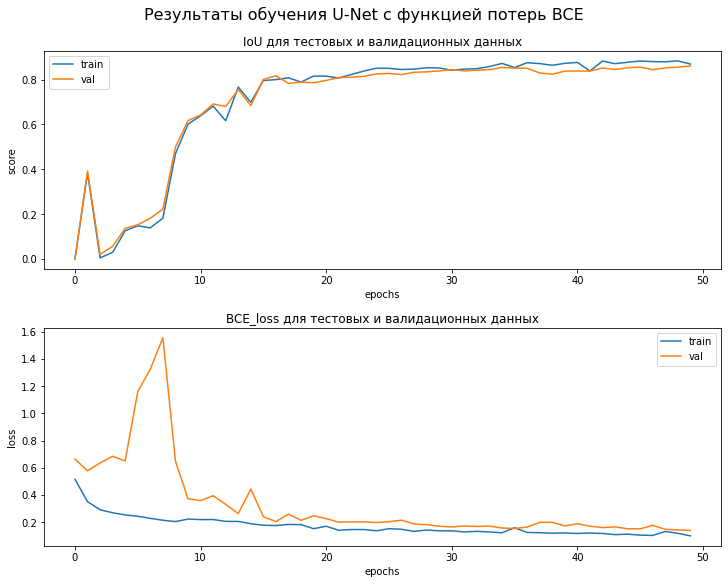

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["train", "val"]
fig.set_size_inches
axs[0].plot(unet_score_h)
axs[0].set_title('IoU для тестовых и валидационных данных')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Результаты обучения U-Net с функцией потерь BCE', fontsize=16)
axs[0].legend(labels)

axs[1].plot(unet_loss_h)
axs[1].set_title('BCE_loss для тестовых и валидационных данных')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].legend(labels)

plt.show()

Теперь проверьте модель UNet c функцией потерь FocalLoss. 

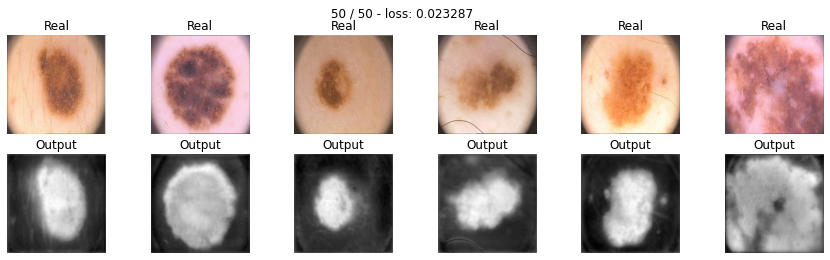

In [ ]:
unet_model_focal = UNet().to(device)
max_epochs = 50
opt_unet_focal = optim.Adam(unet_model_focal.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(opt_unet_focal, step_size = 20, gamma = 0.6)
unet_focal_score_h, unet_focal_loss_h = train(unet_model_focal, opt_unet_focal, focal_loss, max_epochs, data_tr, data_val, scheduler)

In [ ]:
score_model(unet_model_focal, iou_pytorch, data_val)

0.8644947707653046

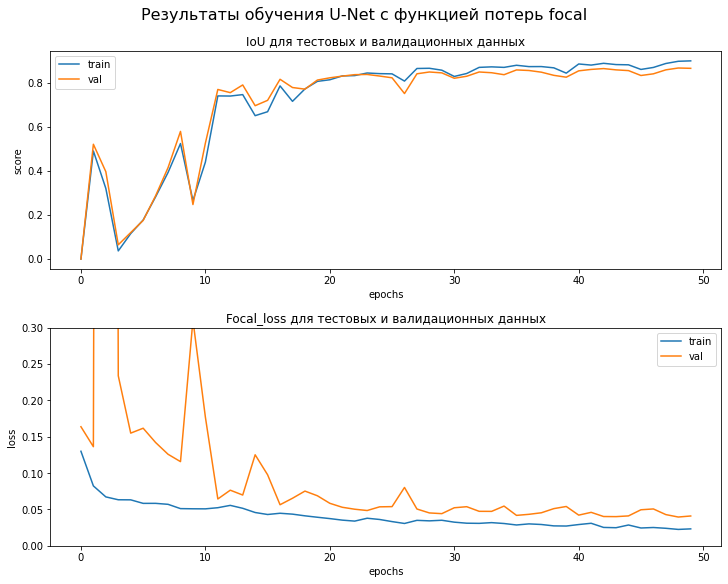

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["train", "val"]
fig.set_size_inches
axs[0].plot(unet_focal_score_h)
axs[0].set_title('IoU для тестовых и валидационных данных')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Результаты обучения U-Net с функцией потерь focal', fontsize=16)
axs[0].legend(labels)

axs[1].plot(unet_focal_loss_h)
axs[1].set_title('Focal_loss для тестовых и валидационных данных')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].axis(ymin=0,ymax=0.3)
axs[1].legend(labels)

plt.show()

Сделайте вывод, какая из моделей лучше.

# Отчёт о проделанной работе
Данная домашняя работа была посвящена сегментации медицинских снимков из датасета ADDI project.

**Цель** данной работы: научиться самостоятельно реализовывать архитектуры CNN для сегментации изображений.

Для достижения данной цели были решены следующие **задачи**:
* непосредственно реализация архитектура двух сетей: **SegNet** и **U-Net**;
* реализация цикла обучения данных сетей;
* оценка качества сетей с помощью метрики IoU;
* реализация трёх функций потерь: BCE loss, Dice loss, Focal loss;
* сравнение качества сетей в зависимости от выбранной функции потерь.


# SegNet

На рис.1а приведены кривые изменения метрики IoU во время обучения (на каждой эпохе) на валидационной выборке для сети SegNet для трёх функций потерь. На рис.1б приведены значения самих лоссов.

In [ ]:
segnet_val_score_bce = [x[1] for x in bce_score_h]
segnet_val_score_dice = [x[1] for x in dice_score_h]
segnet_val_score_focal = [x[1] for x in focal_score_h]
segnet_val_loss_bce = [x[1] for x in bce_loss_h]
segnet_val_loss_dice = [x[1] for x in dice_loss_h]
segnet_val_loss_focal = [x[1] for x in focal_loss_h]

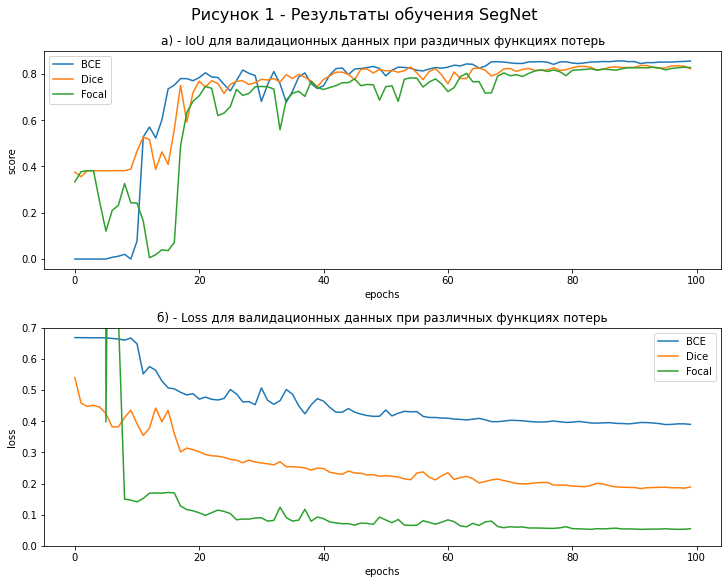

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["BCE", "Dice", "Focal"]
fig.set_size_inches
axs[0].plot(segnet_val_score_bce)
axs[0].plot(segnet_val_score_dice)
axs[0].plot(segnet_val_score_focal)
axs[0].set_title('а) - IoU для валидационных данных при раздичных функциях потерь')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Рисунок 1 - Результаты обучения SegNet', fontsize=16)
axs[0].legend(labels)

axs[1].plot(segnet_val_loss_bce)
axs[1].plot(segnet_val_loss_dice)
axs[1].plot(segnet_val_loss_focal)
axs[1].set_title('б) - Loss для валидационных данных при различных функциях потерь')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].axis(ymin=0,ymax=0.7)
axs[1].legend(labels)

plt.show()

Проанализировав графики можно сделать вывод о том, что SegNet успешно обучается со всеми тремя функциями потерь и выходит на плато примерно после 80й эпохи. Значение потерь стабильно падают. В таблице №1 приведены значения метрики для валидационных данных для сети SegNet, а так же значения потерь.

In [ ]:
import pandas as pd

segnet = {'SegNet': ['BCE','Dice','Focal'],
        'IoU score': [segnet_val_score_bce[-1], segnet_val_score_dice[-1], segnet_val_score_focal[-1]],
        'Model loss': [float(segnet_val_loss_bce[-1]), float(segnet_val_loss_dice[-1]), float(segnet_val_loss_focal[-1])]
        }

df_segnet = pd.DataFrame(segnet, columns = ['SegNet', 'IoU score', 'Model loss'])

In [ ]:
print('Сводная таблица для SegNet')
print (df_segnet)

Сводная таблица для SegNet
  SegNet  IoU score  Model loss
0    BCE   0.855634    0.389980
1   Dice   0.822606    0.188693
2  Focal   0.827275    0.054745


Можно заметить, что SegNet с BCE loss дала наилучший результат метрики на валидационной выборке, хотя отличие от dice и focal составило менее 5%.

**Вывод**: 
* SegNet вне зависимости от выбранной функции потерь позволяет сегментироваить изображения из предложенного датасета
* Разница в метрике IoU для BCE, Dice, Focal менее 5%
* Лучший скор на виладационной выборке **0.855**

# U-Net
На следующем этапе работы была реализована другая архитектура сети - U-Net.
На рис.2а приведены кривые изменения метрики IoU во время обучения 
(на каждой эпохе) на валидационной выборке для сети U-Net для трёх функций
 потерь. На рис.2б приведены значения самих лоссов.

In [ ]:
unet_val_score_bce = [x[1] for x in unet_score_h]
unet_val_score_focal = [x[1] for x in unet_focal_score_h]
unet_val_loss_bce = [x[1] for x in unet_loss_h]
unet_val_loss_focal = [x[1] for x in unet_focal_loss_h]

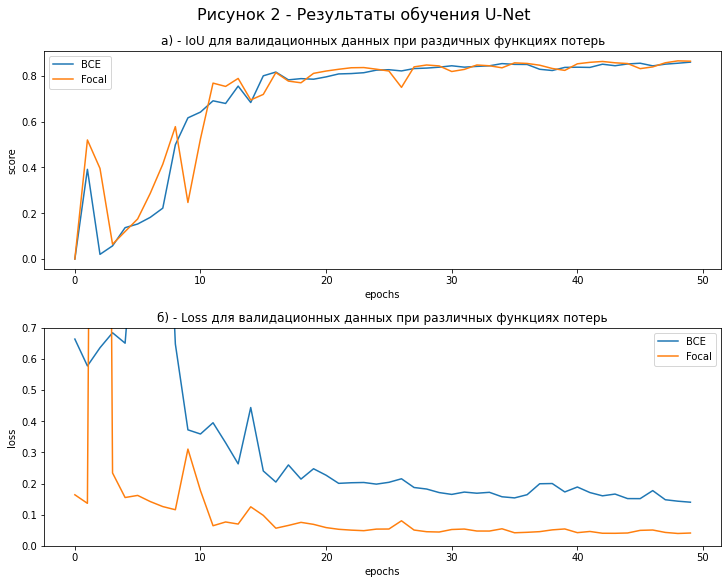

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True)
labels = ["BCE", "Focal"]
fig.set_size_inches
axs[0].plot(unet_val_score_bce)
axs[0].plot(unet_val_score_focal)
axs[0].set_title('а) - IoU для валидационных данных при раздичных функциях потерь')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('score')
fig.suptitle('Рисунок 2 - Результаты обучения U-Net', fontsize=16)
axs[0].legend(labels)

axs[1].plot(unet_val_loss_bce)
axs[1].plot(unet_val_loss_focal)
axs[1].set_title('б) - Loss для валидационных данных при различных функциях потерь')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].axis(ymin=0,ymax=0.7)
axs[1].legend(labels)

plt.show()

Аналогичным образом проанализировав графики можно сделать вывод о том, что U-Net успешно обучается со BCE и Focal loss и выходит на плато примерно после 30й эпохи, что существенно быстрее, чем SegNet. Необходимо отметить, что процесс обучения одной эпохи длится дольше у U-Net, чем у SegNet. Кроме того, при выводе сегментированного изображения, картинки U-Net позволяют выделить существенно больше деталий, чем SegNet.

В таблице №2 приведены значения метрики для валидационных данных для сети U-Net, а так же значения потерь. Можно заметить, что метрика по результатам обучения практически не отличается: разница между BCE и focal составила менее 1%

In [ ]:
unet = {'U-Net': ['BCE','Focal'],
        'IoU score': [unet_val_score_bce[-1], unet_val_score_focal[-1]],
        'Model loss': [float(unet_val_loss_bce[-1]), float(unet_val_loss_focal[-1])]
        }

df_unet = pd.DataFrame(unet, columns = ['U-Net', 'IoU score', 'Model loss'])

In [ ]:
print('Сводная таблица для U-Net')
print (df_unet)

Сводная таблица для U-Net
   U-Net  IoU score  Model loss
0    BCE   0.860340    0.139991
1  Focal   0.864495    0.041017


**Вывод**: 
* U-Net вне зависимости от выбранной функции потерь позволяет сегментироваить изображения из предложенного датасета
* U-Net обучается быстрее SegNet
* Лучшее качество визуализации сегментирования
* Разница в метрике IoU менее 1%
* Лучший скор на валидационной выборке **0.864**

# Выводы
В рамках данной домашней работы изучались две архитектуры CNN для сегментации изображения **SegNet** и **U-Net**. В качестве датасета выступал ADDI project. Метрикой качества являются **IoU**.
В таблице №3 приведены сводные значения метрики IoU, а так же функций потерь для обеих архитектур CNN.

In [ ]:
total = {'Metric': ['IoU_score_BCE', 'IoU_score_Dice', 'IoU_score_Focal', 
                    'Loss_BCE', 'Loss_Dice', 'Loss_Focal'],
         'SegNet': [segnet_val_score_bce[-1], segnet_val_score_dice[-1], 
                    segnet_val_score_focal[-1], float(segnet_val_loss_bce[-1]), 
                    float(segnet_val_loss_dice[-1]), 
                    float(segnet_val_loss_focal[-1])],
         'U-Net': [unet_val_score_bce[-1],'-', unet_val_score_focal[-1], 
                   float(unet_val_loss_bce[-1]), '-', float(unet_val_loss_focal[-1])]}

df_total = pd.DataFrame(total, columns = ['Metric', 'SegNet', 'U-Net'])

In [ ]:
print('Сводная таблица для SegNet и U-Net')
print (df_total)

Сводная таблица для SegNet и U-Net
            Metric    SegNet      U-Net
0    IoU_score_BCE  0.855634    0.86034
1   IoU_score_Dice  0.822606          -
2  IoU_score_Focal  0.827275   0.864495
3         Loss_BCE  0.389980   0.139991
4        Loss_Dice  0.188693          -
5       Loss_Focal  0.054745  0.0410169


**Выводы**: 
* Качество сегментации U-Net согласно метрике IoU не существенно превышает качество сегментации SegNet
* U-Net обучается быстрее (суммарное время обучения) SegNet
* U-Net даёт качество визуализации сегментирования
* **Наилучшего** результата на валидационной выборке удалось достчись с моделью сети **U-Net** и функцией потерь **Focal loss**. **IoU = 0.864**

P.S.
Уважаемые авторы курса!
Хотелось бы сказать вам большое спасибо за эту домашнюю работу, хотя времени и нервов было потрачено неимоверное количество.
Хотелось бы пожелать в следующий раз выбрать какой-то "более приятный глазу" датасет и посоветовать фиксировать random_state.